Team : Ruila PUSKAS-JUHASZ and Agathe LHOPITEAU

# Challenge SD-TSIA210

In [1]:
%matplotlib inline
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import optimizers

Using TensorFlow backend.


### Load and investigate the Data

In [2]:
Xtrain = np.loadtxt('xtrain_challenge.csv', delimiter=',', skiprows = 1)
Ytrain = np.loadtxt('ytrain_challenge.csv', delimiter=',', skiprows = 1)
Xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)

#Let's check the shape of the training sets
print(Xtrain.shape)
print(Ytrain.shape)

#Using our own training data to test
#X_train, X_test, Y_train, Y_test = train_test_split(Xtrain, Ytrain, test_size = 0.20)
#print(X_train.shape,Y_train.shape)
#print(X_test.shape,Y_test.shape)

OSError: xtrain_challenge.csv not found.

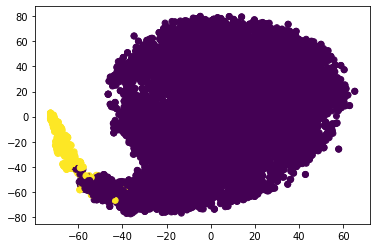

In [11]:
#Let's visualize the first 10.000 inputs of our dataset
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(Xtrain[:10000])

X,Y=[],[]
for i in range(len(X_embedded)) :
    X.append(X_embedded[i][0])
    Y.append(X_embedded[i][1])

plt.scatter(X, Y, c=Ytrain[:10000])
plt.show()

In [6]:
#Scaling the data for more efficiency during learning processes
Xtrain = preprocessing.scale(Xtrain)
Xtest = preprocessing.scale(Xtest)

## Let's try a few methods


With the K-nearest neighbours method, we get a computation time of approximately 5 minutes and we get an accuracy of 0.9975245787338384, when we take 3 neighbors. 

## Deep Neural Network

In [ ]:
data = Xtrain[:100000]
labels = Ytrain[:100000]
modelDNN = Sequential()
modelDNN.add(Dense(32,activation='softmax',input_dim=37))
modelDNN.add(Dense(1, activation='sigmoid'))
modelDNN.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])


modelDNN.fit(data,labels,epochs=10,batch_size=32)
predictions = modelDNN.predict(data)
 

For 10000 features, we get very good accuracies: 0.9627 0.9857 0.9592 0.9589 0.9589 0.9589 0.9859 0.9969 0.9973 0.9973 <br>

## Random Forrest

In [ ]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(Xtrain, Ytrain, test_size = 0.20)

from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(Xtrain[:10000], Ytrain[:10000])

In [ ]:
Ypred_forest = model.predict(Xtest)

In [ ]:
#Let's create our file that will be compared to Ytest
np.savetxt('ytest_challenge_LHOPITEAU.csv', Ypred_forest, fmt = '%1.0d', delimiter=',')

Using only this random forest, we have a pretty good result : accuracy of 0.998063463898. Moreover, the computing time isn't very long, so this method is pretty efficient and we decide to keep it for our ensemble learning.

## Logistic regression 

In [7]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(Xtrain[:10000], Ytrain[:10000])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
Ypred_logreg = logreg.predict(Xtest)

In [9]:
#Let's create our file that will be compared to Ytest
np.savetxt('ytest_challenge_LHOPITEAU.csv', Ypred_logreg, fmt = '%1.0d', delimiter=',')

This method provides a pretty good accuracy : 0.9978, and is computed very quickly (less than 5 minutes). We thus decide to keep it for our futur ensemble learning.

## K-nearest neighbours

In [ ]:
############WITHOUT ENSEMBLES###################
#We fix the number of neighbors equal to 100
#clfKNN = KNeighborsClassifier(n_neighbors=100)
#clfKNN = clfKNN.fit(Xtrain, Ytrain)

#We predict the labels 
#Ypred_knn = clfKNN.predict(Xtest)

#Compute the accuracy
#accuracy_score(Ypred_knn, Y_test)


###########WITH ENSEMBLES########################
#create new a knn model
knn = KNeighborsClassifier()

#We want to test 30 different values for each neighbor
params_knn = {'n_neighbors': np.arange(1, 9)}

#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=3)

#fit model to training data
knn_gs.fit(Xtrain[:10000], Ytrain[:10000])

#save best model
knn_best = knn_gs.best_estimator_

#check best n_neigbors value
print(knn_gs.best_params_)

#Prepare for submission
#np.savetxt('ytest_knn.csv', Ypred_knn, fmt = '%1.0d', delimiter = ',')

#Prepare for submission
ytest_knn = knn_best.predict(Xtest)
#np.savetxt('ytest_knn.csv', ytest_knn, fmt = '%1.0d', delimiter = ',')

Knn is very quick for features under 100 000, after it is rather slow. To get free from this long computation of the grid search and of the fit, we will test manually the results given by this code for 1000, 10000, 100 000 features. We see that there is a tendancy: the number of neighbours seems to tend towards 3, so we will keep this parameter in the following cell. 

## Now let's vote for best classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[("knn", knn_best), ("log_reg", logreg), ("random_forrest", model)]

#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting="hard")

In [ ]:
#test the three models with the test data and print their accuracy scores
print("knn: {}".format(knn_best.score(X_test, Y_test)))
print("DNN: {}".format(modelDNN.evaluate(X_test, Y_test, batch_size = 32)))
print("random_forrest: {}".format(model.score(X_test, Y_test)))
print("log_reg: {}".format(logreg.score(X_test, Y_test)))

ATTENTION Agathe quand tu run le code parce que j'avais fait un train test split au début donc à certains endroits il faut enlever les underscores ;)

In [ ]:
#fit model to training data
ensemble.fit(Xtrain[:10000], Ytrain[:10000])
#test our model on the test data
ensemble.score(Xtest, Ytest)

For 1000 features, we get a final accuracy of 0.9955 which is lower than when we use only the random forrest. 
When we increase the number of features however, this accuracy increases as well: 0.9976696412276966 for 10000 features